In [46]:
import numpy as np


class AdalineGD(object):
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta  # 学習率 : float
        self.n_iter = n_iter  # 訓練回数 : int
        self.random_state = random_state  # 重みの初期化用の乱数

    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

    @staticmethod
    def activation(X):
        return X

    def predict(self, X):
        return np.where(self.activation(self.net_input(X)) >= 0.0, 1, -1)

    # X: 訓練データセット
    # y: 目的変数
    def fit(self, X, y):
        gen = np.random.RandomState(self.random_state)
        self.w_ = gen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])  # 重み配列
        self.cost_ = []

        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)

            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()

            cost = (errors ** 2).sum() / 2.0
            self.cost_.append(cost)
        return self

In [47]:
from matplotlib.colors import ListedColormap


def plot_decision_regions(X, y, classifier, resolution=0.02):
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))

    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)

    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
                    y=X[y == cl, 1],
                    alpha=0.8,
                    c=colors[idx],
                    marker=markers[idx],
                    label=cl,
                    edgecolor='black')


In [48]:
import pandas as pd

df = pd.read_csv('../../data/iris/iris.data', header=None, encoding='utf-8')
X = df.iloc[0:100, [0, 2]].values
y_all = df.iloc[0:100, 4].values
y = np.where(y_all == 'Iris-setosa', -1, 1)


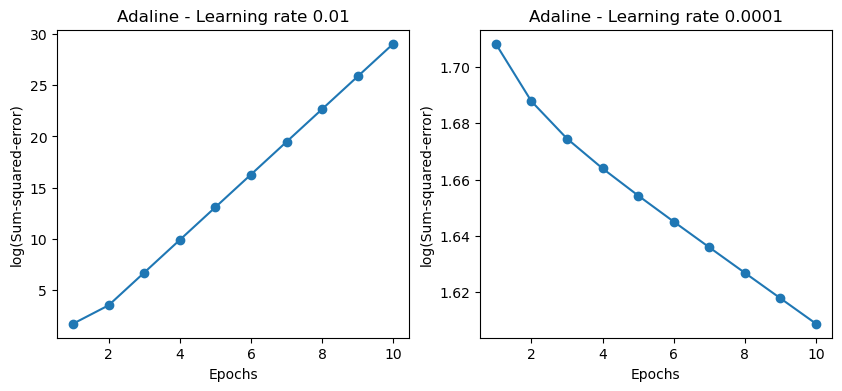

In [49]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

ada1 = AdalineGD(n_iter=10, eta=0.01).fit(X, y)

ax[0].plot(range(1, len(ada1.cost_) + 1), np.log10(ada1.cost_), marker='o')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('log(Sum-squared-error)')
ax[0].set_title('Adaline - Learning rate 0.01')

ada2 = AdalineGD(n_iter=10, eta=0.0001).fit(X, y)

ax[1].plot(range(1, len(ada2.cost_) + 1), np.log10(ada2.cost_), marker='o')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('log(Sum-squared-error)')
ax[1].set_title('Adaline - Learning rate 0.0001')

plt.show()

<ipython-input-47-4d7b82776585>:22: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],


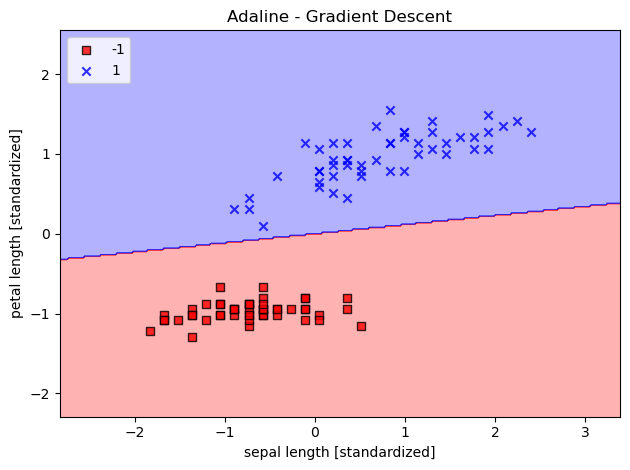

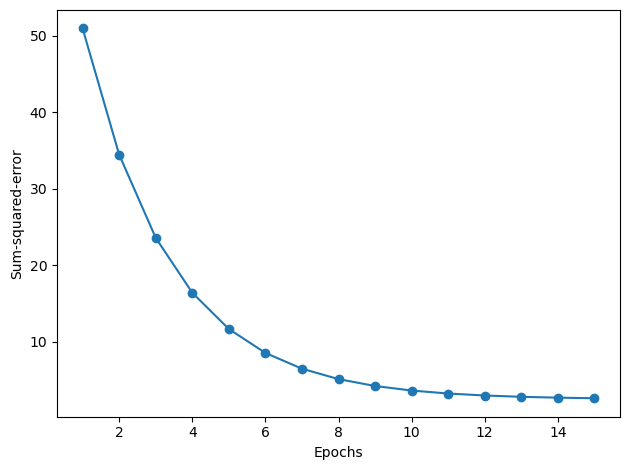

In [50]:
X_std = np.copy(X)
X_std[:, 0] = (X[:, 0] - X[:, 0].mean()) / X[:, 0].std()
X_std[:, 1] = (X[:, 1] - X[:, 1].mean()) / X[:, 1].std()

ada_gd = AdalineGD(n_iter=15, eta=0.01)
ada_gd.fit(X_std, y)

plot_decision_regions(X_std, y, classifier=ada_gd)
plt.title('Adaline - Gradient Descent')
plt.xlabel('sepal length [standardized]')
plt.ylabel('petal length [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

plt.plot(range(1, len(ada_gd.cost_) + 1), ada_gd.cost_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Sum-squared-error')
plt.tight_layout()
plt.show()

In [51]:
from numpy.random import seed


class AdalineSGD(object):
    def __init__(self, eta=0.01, n_iter=50, shuffle=True, random_state=None):
        self.eta = eta  # 学習率 : float
        self.n_iter = n_iter  # 訓練回数 : int
        self.w_initialized = False  # 重みの初期化フラグ
        self.shuffle = shuffle  # 訓練データのシャッフルフラグ
        self.random_state = random_state  # 重みの初期化用の乱数

    # 重みの初期化処理
    def _initialize_weights(self, m):
        self.gen = np.random.RandomState(self.random_state)
        self.w_ = self.gen.normal(loc=0.0, scale=0.01, size=1 + m)
        self.w_initialized = True

    # データをシャッフル
    def _shuffle(self, X, y):
        r = self.gen.permutation(len(y))
        return X[r], y[r]

    def _update_weights(self, xi, target):
        output = self.activation(self.net_input(xi))
        error = (target - output)

        self.w_[1:] += self.eta * xi.T.dot(error)
        self.w_[0] += self.eta * error

        cost = (error ** 2) / 2.0
        return cost

    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

    @staticmethod
    def activation(X):
        return X

    def predict(self, X):
        return np.where(self.activation(self.net_input(X)) >= 0.0, 1, -1)

    # X: 訓練データセット
    # y: 目的変数
    def fit(self, X, y):
        self._initialize_weights(X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            cost = []
            for xi, target in zip(X, y):
                cost.append(self._update_weights(xi, target))

            avg_cost = sum(cost) / len(y)
            self.cost_.append(avg_cost)
        return self

    def partial_fit(self, X, y):
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        else:
            self._update_weights(X, y)
        return self

<ipython-input-47-4d7b82776585>:22: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],


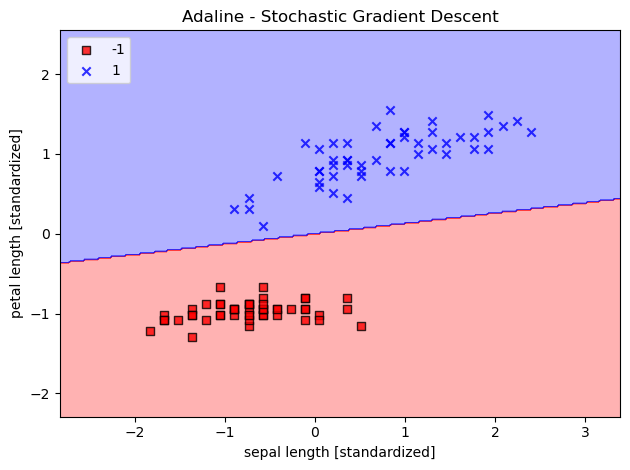

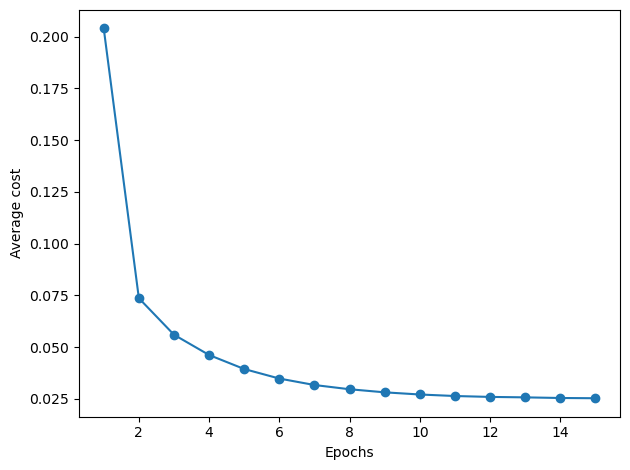

In [52]:
ada_sgd = AdalineSGD(n_iter=15, eta=0.01, random_state=1)
ada_sgd.fit(X_std, y)

plot_decision_regions(X_std, y, classifier=ada_sgd)
plt.title('Adaline - Stochastic Gradient Descent')
plt.xlabel('sepal length [standardized]')
plt.ylabel('petal length [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

plt.plot(range(1, len(ada_sgd.cost_) + 1), ada_sgd.cost_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Average cost')
plt.tight_layout()
plt.show()